In [1]:
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from kgcnn.data.datasets.cora_lu import CoraLUDataset
from kgcnn.literature.GCN import make_model
from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
from kgcnn.utils.adj import precompute_adjacency_scaled, sort_edge_indices, make_adjacency_from_edge_indices, \
    make_adjacency_undirected_logical_or, convert_scaled_adjacency_to_list
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import LinearLearningRateScheduler

## Loading graph data

In [2]:
dataset = CoraLUDataset()
nodes, edge_index, labels, class_label_mapping = dataset.node_attributes, dataset.edge_indices, dataset.node_labels, dataset.class_label_mapping
labels = labels[0]
nodes = nodes[0][:, 1:]  # Remove IDs
edge_index = sort_edge_indices(edge_index[0])
adj_matrix = make_adjacency_from_edge_indices(edge_index)
adj_matrix = precompute_adjacency_scaled(make_adjacency_undirected_logical_or(adj_matrix))
edge_index, edge_weight = convert_scaled_adjacency_to_list(adj_matrix)
edge_weight = np.expand_dims(edge_weight, axis=-1)
# labels = np.expand_dims(labels, axis=-1)
# labels = np.array(labels == np.arange(7), dtype=np.float32)

# Find a color to visualize a label
def get_label_color(label):
    return plt.get_cmap('Set1')(label / 7)


# Map label to class
def get_label_name(label):
    return ["Case_Based",
            "Genetic_Algorithms",
            "Neural_Networks",
            "Probabilistic_Methods",
            "Reinforcement_Learning",
            "Rule_Learning",
            "Theory"][label]


INFO:kgcnn: Dataset directory located at C:\Users\Patrick\.kgcnn\datasets
INFO:kgcnn: Dataset directory found... done
INFO:kgcnn: Dataset found... done
INFO:kgcnn: Directory for extraction exists... done
INFO:kgcnn: Not extracting tar File... stopped


## Train test split

In [3]:
# Make test/train split
# Since only one graph in the dataset
# Use a mask to hide test nodes labels
inds = np.arange(len(labels))
ind_train, ind_val = train_test_split(inds, test_size=0.10, random_state=0)
val_mask = np.zeros_like(inds)
train_mask = np.zeros_like(inds)
val_mask[ind_val] = 1
train_mask[ind_train] = 1
val_mask = np.expand_dims(val_mask, axis=0)  # One graph in batch
train_mask = np.expand_dims(train_mask, axis=0)  # One graph in batch

# Make ragged graph tensors with 1 graph in batch
nodes, edges, edge_indices = ragged_tensor_from_nested_numpy([nodes]), ragged_tensor_from_nested_numpy(
    [edge_weight]), ragged_tensor_from_nested_numpy([edge_index])  # One graph in batch

# Set training data. But requires mask and batch-dimension of 1
xtrain = nodes, edges, edge_indices
ytrain = np.expand_dims(labels, axis=0)  # One graph in batch
print([x.shape for x in xtrain])
print(ytrain.shape)

[TensorShape([1, None, 1432]), TensorShape([1, None, 1]), TensorShape([1, None, 2])]
(1, 2708, 7)


## Train GCN model on cora dataset

INFO:kgcnn: Updated model kwargs:
{'depth': 3,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'pooling_method': 'sum',
              'units': 124,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 95, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 1432)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'GCN',
 'output_embedding': 'node',
 'output_mlp': {'activation': ['relu', 'relu', 'softmax'],
                'units': [64, 16, 7],
                'use_bias': [True, True, False]},
 'verbose': 

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_attributes (InputLayer)    [(None, None, 1432)] 0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 124)    177692      node_attributes[0][0]            
__________________________________________________________________________________________________
edge_attributes (InputLayer)    [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
edge_indices (InputLayer)       [(None, None, 2)]    0                                            
______________________________________________________________________________________________

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/change_tensor_type/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/change_tensor_type/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 7), dtype=float32), dense_shape=Tensor("gradient_tape/model/change_tensor_type/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_

1/1 - 2s - loss: 1.7524 - categorical_accuracy: 0.1194
Epoch 2/10
1/1 - 0s - loss: 1.7413 - categorical_accuracy: 0.3697
Epoch 3/10
1/1 - 0s - loss: 1.7305 - categorical_accuracy: 0.5043
Epoch 4/10
1/1 - 0s - loss: 1.7149 - categorical_accuracy: 0.5244
Epoch 5/10
1/1 - 0s - loss: 1.6941 - categorical_accuracy: 0.5334
Epoch 6/10
1/1 - 0s - loss: 1.6676 - categorical_accuracy: 0.5478
Epoch 7/10
1/1 - 0s - loss: 1.6340 - categorical_accuracy: 0.5556
Epoch 8/10
1/1 - 0s - loss: 1.5919 - categorical_accuracy: 0.5630
Epoch 9/10
1/1 - 0s - loss: 1.5405 - categorical_accuracy: 0.5716
Epoch 10/10
1/1 - 0s - loss: 1.4799 - categorical_accuracy: 0.5700
1/1 [==============================] - 0s 418ms/step - loss: 0.1617 - categorical_accuracy: 0.5387
Epoch 11/20
1/1 - 0s - loss: 1.4112 - categorical_accuracy: 0.5728
Epoch 12/20
1/1 - 0s - loss: 1.3361 - categorical_accuracy: 0.5815
Epoch 13/20
1/1 - 0s - loss: 1.2578 - categorical_accuracy: 0.5884
Epoch 14/20
1/1 - 0s - loss: 1.1802 - categorical_

Epoch 109/110
1/1 - 0s - loss: 0.0705 - categorical_accuracy: 0.9721
Epoch 110/110
1/1 - 0s - loss: 0.0688 - categorical_accuracy: 0.9713
1/1 [==============================] - 0s 26ms/step - loss: 0.0753 - categorical_accuracy: 0.8598
Epoch 111/120
1/1 - 0s - loss: 0.0681 - categorical_accuracy: 0.9717
Epoch 112/120
1/1 - 0s - loss: 0.0687 - categorical_accuracy: 0.9750
Epoch 113/120
1/1 - 0s - loss: 0.0682 - categorical_accuracy: 0.9713
Epoch 114/120
1/1 - 0s - loss: 0.0662 - categorical_accuracy: 0.9750
Epoch 115/120
1/1 - 0s - loss: 0.0644 - categorical_accuracy: 0.9725
Epoch 116/120
1/1 - 0s - loss: 0.0638 - categorical_accuracy: 0.9750
Epoch 117/120
1/1 - 0s - loss: 0.0634 - categorical_accuracy: 0.9770
Epoch 118/120
1/1 - 0s - loss: 0.0624 - categorical_accuracy: 0.9746
Epoch 119/120
1/1 - 0s - loss: 0.0613 - categorical_accuracy: 0.9787
Epoch 120/120
1/1 - 0s - loss: 0.0610 - categorical_accuracy: 0.9746
1/1 [==============================] - 0s 28ms/step - loss: 0.0794 - categ

Epoch 213/220
1/1 - 0s - loss: 0.0306 - categorical_accuracy: 0.9885
Epoch 214/220
1/1 - 0s - loss: 0.0446 - categorical_accuracy: 0.9815
Epoch 215/220
1/1 - 0s - loss: 0.0800 - categorical_accuracy: 0.9631
Epoch 216/220
1/1 - 0s - loss: 0.2509 - categorical_accuracy: 0.9134
Epoch 217/220
1/1 - 0s - loss: 0.3656 - categorical_accuracy: 0.9060
Epoch 218/220
1/1 - 0s - loss: 0.0457 - categorical_accuracy: 0.9811
Epoch 219/220
1/1 - 0s - loss: 0.2445 - categorical_accuracy: 0.9220
Epoch 220/220
1/1 - 0s - loss: 0.0453 - categorical_accuracy: 0.9824
1/1 [==============================] - 0s 27ms/step - loss: 0.1316 - categorical_accuracy: 0.8524
Epoch 221/230
1/1 - 0s - loss: 0.1456 - categorical_accuracy: 0.9508
Epoch 222/230
1/1 - 0s - loss: 0.0871 - categorical_accuracy: 0.9680
Epoch 223/230
1/1 - 0s - loss: 0.0552 - categorical_accuracy: 0.9741
Epoch 224/230
1/1 - 0s - loss: 0.1224 - categorical_accuracy: 0.9499
Epoch 225/230
1/1 - 0s - loss: 0.0447 - categorical_accuracy: 0.9795
Epoch

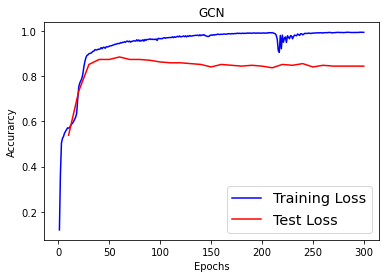

1/1 [==============================] - 0s 28ms/step - loss: 0.1251 - categorical_accuracy: 0.8450


[0.12514738738536835, 0.8450184464454651]

In [4]:
model = make_model(
    inputs= [{'shape': (None, 1432), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
             {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
             {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
    output_embedding = 'node',
    output_mlp = {"use_bias": [True, True, False], "units": [64, 16, 7], "activation": ['relu', 'relu', 'softmax']},
    gcn_args = {"units": 124, "use_bias": True, "activation": 'relu', "pooling_method": 'sum'},
    depth = 3, 
    verbose =  1
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 300
epomin = 260
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['categorical_accuracy'])
print(model.summary())

# Training loop
trainlossall = []
testlossall = []
start = time.process_time()
for iepoch in range(0, epo, epostep):
    hist = model.fit(xtrain, ytrain,
                     epochs=iepoch + epostep,
                     initial_epoch=iepoch,
                     batch_size=1,
                     callbacks=[cbks],
                     verbose=2,
                     sample_weight=train_mask  # Important!!!
                     )

    trainlossall.append(hist.history)
    testlossall.append(model.evaluate(xtrain, ytrain, sample_weight=val_mask))
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Pick out accuracy
testlossall = np.array(testlossall)
trainlossall = np.concatenate([x['categorical_accuracy'] for x in trainlossall])

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(1, len(trainlossall) + 1), trainlossall, label='Training Loss', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall[:, 1], label='Test Loss', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GCN')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gcn_explain_loss_cora.png')
plt.show()

# Evaluate model
model.evaluate(xtrain, ytrain, sample_weight=val_mask)

## Explaining Predictions


Implementing the GNNInterface:

In [5]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, node_index, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model
        self.node_index = node_index

    def predict(self, gnn_input, masking_info=None):
        return tf.expand_dims(self.gnn_model(gnn_input, training=False)[0][self.node_index], 0)

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(edge_input, tf.float32),
                                                      edge_mask)
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        masked_pred = tf.expand_dims(
            self.gnn_model([masked_feature_input, masked_edge_input, edge_index_input], training=training)[0][
                self.node_index], 0)
        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[1]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask, node_labels=None):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        g = nx.Graph()
        for i, f in enumerate(features):
            if node_labels is None:
                g.add_node(i, features=f, relevance=node_relevance[i])
            else:
                g.add_node(i, features=f, relevance=node_relevance[i], label=node_labels[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                g.add_edge(e[0], e[1])
            else:
                g.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return g

    def present_explanation(self, explanation, threshold=0.5):
        relevant_edges = []
        edge_color_map = []
        for (v, u, relevance) in explanation.edges.data('relevance'):
            if relevance > threshold:
                relevant_edges.append((v, u))
                edge_color_map.append((0, 0, 0, relevance))
        subgraph = explanation.edge_subgraph(relevant_edges)
        node_colors = []
        for n, l in subgraph.nodes.data('label'):
            r, g, b, a = get_label_color(l)
            a = subgraph.nodes[n]['relevance']
            node_colors.append((r, g, b, a))
        nx.draw(subgraph, node_color=node_colors, edge_color=edge_color_map, with_labels=True)

In [6]:
# Helper functions
def get_output_tensor_for_label(label):
    assert 0 <= label <= 6
    output_to_explain = np.zeros(7)
    output_to_explain[label] = 1.
    output_to_explain = np.expand_dims(output_to_explain, 0)
    return tf.Variable(output_to_explain)


def get_label_from_tensor(tensor_output):
    return np.argmax(tensor_output)

Choose a node to explain and instantiate an explainable GNN:

In [7]:
node_index = np.argwhere(val_mask[0] == 1)[:, 0][0]
# node_index = 9
explainable_gcn = ExplainableGCN(model, node_index)

Get the prediction of the GNN for the chosen node:

In [8]:
prediction = explainable_gcn.predict(xtrain)
predicted_label = get_label_from_tensor(prediction)
print('predicted label: ', predicted_label, get_label_name(predicted_label))
print("true label:", get_label_from_tensor(labels[node_index]))
print('node_index: ', node_index)

predicted label:  2 Neural_Networks
true label: 2
node_index:  9


Setup the GNNExplainer:

In [9]:
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                                 'edge_mask_norm_ord': 2,
                                 'feature_mask_loss_weight': 0,
                                 'feature_mask_norm_ord': 2,
                                 'node_mask_loss_weight': 0,
                                 'node_mask_norm_ord': 1}
compile_options = {'loss': 'categorical_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=1)}
fit_options = {'epochs': 80, 'verbose': 0}

explainer = GNNExplainer(explainable_gcn,
                         compile_options=compile_options,
                         fit_options=fit_options,
                         gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Explain the instance with index node_index:

In [10]:
%%capture
inspection_result = explainer.explain(xtrain, inspection=True)

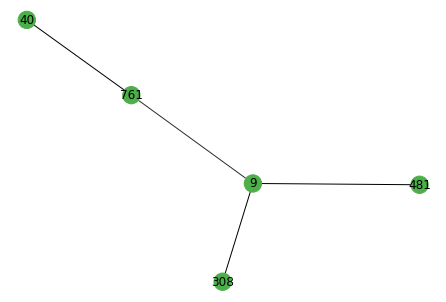

In [11]:
plt.figure()
explainer.present_explanation(explainer.get_explanation(node_labels=np.argmax(ytrain[0], axis=1)), threshold=0.1)
plt.show()

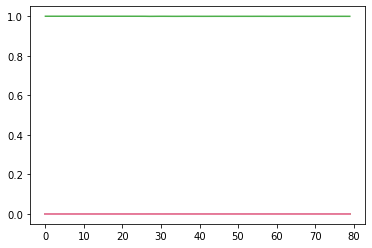

In [12]:
# Plot the inspection_result to see if we chose suitable parameters:
plt.figure()
for i in range(7):
    plt.plot(np.array(inspection_result['predictions'])[:, i], color=get_label_color(i))
plt.show()

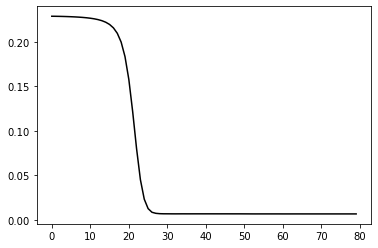

In [13]:
# Plot Loss
plt.figure()
plt.plot(np.array(inspection_result['total_loss']), color="black")
plt.show()

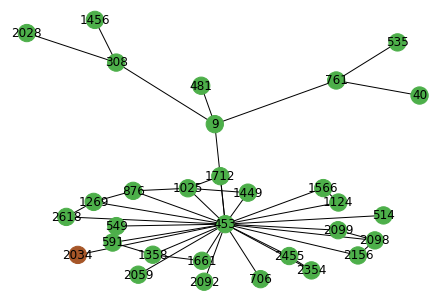

In [14]:
# For comparison, the 2-hop graph around the chosen instance:
plt.figure()
cora_graph = nx.Graph()
cora_graph.add_nodes_from([(i, {"label": labels[i]}) for i in inds])
cora_graph.add_edges_from(edge_index)
hops = 2
khopgraph = nx.generators.ego.ego_graph(cora_graph, node_index, radius=hops)
for n in khopgraph.nodes:
    khopgraph.nodes[n]['label'] = np.argmax(khopgraph.nodes[n]['label'])
    khopgraph.nodes[n]['relevance'] = 1.
for (u, v) in khopgraph.edges:
    khopgraph.edges[u, v]['relevance'] = 1.0
explainer.present_explanation(khopgraph)
plt.show()